In [2]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=Warning)

In [7]:
# load data
df = pd.read_csv("Article_bottom10_Data.csv")
# group by Date
df['Day'] = df['Date'].map(lambda x: 1 if len(pd.bdate_range(x, x)) else 0 )

# group by Hour
df['Hour'] = df['Hour'].map(lambda x: 0 if int(x)>=5 and int(x)<=8
                                            else 1 if int(x)>=9 and int(x)<=12
                                            else 2 if int(x)>=13 and int(x)<=16
                                            else 3)


df.head()

,Unnamed: 0,Date,StoreNumber,CashRegisterNumber,ReceiptNumber,ReceiptRowNumber,Time,ArticleNumber,ArticleName,Quantity,Timestamp,Month,Day,Hour
0,1060403,2022-01-15,1001,2,835,9,10:50:44,28224,NRW Rahmk.Pfef.St.ca.220g,0.448,2022-01-15 10:50:44,1,0,1
1,1306869,2022-01-18,1033,1,495,15,17:15:28,840247,Cordon Bleu-Roellchen,0.158,2022-01-18 17:15:28,1,1,3
2,1855511,2022-01-24,1223,2,822,17,11:52:05,840265,Schweine-Nackensteak gef.,0.366,2022-01-24 11:52:05,1,1,1
3,1887826,2022-01-24,1417,2,22,25,10:24:21,840499,Thuer.Leberkaese,0.122,2022-01-24 10:24:21,1,1,1
4,4597736,2022-02-23,1033,3,984,24,18:08:17,840811,Pikanter Braten,0.154,2022-02-23 18:08:17,2,1,3


In [8]:
print(df.shape)
df.ArticleName.unique()

(30, 14)


array(['NRW Rahmk.Pfef.St.ca.220g', 'Cordon Bleu-Roellchen',
       'Schweine-Nackensteak gef.', 'Thuer.Leberkaese', 'Pikanter Braten',
       'Rinder-Spiess mariniert', 'Hackepeter vom Schwein',
       'Schinken-Krustenbr. gep.', 'Stroh S-Loinribs mar.',
       'Spanferkelruecken aufget.', 'Champignon-Spiess v.Schw.',
       'Schweine-Loinribs', 'Rinder-Filet Mittelstueck',
       'SB Kasseler Lachsbraten ca.1,5kg', 'Enten-Keule',
       'Hausmacher Schw.-Roulade', 'Zicklein halb', 'Wild-Gulasch',
       'Rinderrohschinken', 'Haehnchen-Spiess Hawaii'], dtype=object)

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso

from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [4]:
# encoder = LabelEncoder()
# df['StoreNumber'] = encoder.fit_transform(df['StoreNumber'])
# store_mapping = {index : label for index, label in enumerate(encoder.classes_)}
# print(store_mapping)

# df['ArticleName'] = encoder.fit_transform(df['ArticleName'])
# article_mapping = {index : label for index, label in enumerate(encoder.classes_)}
# print(article_mapping)

## BO-Laugenbreze 1ST

In [14]:
article = df.loc[:,['StoreNumber', 'Quantity', 'Month', 'Day','Hour']][df.Group == 'BO-Laugenbreze 1ST']
article = article.groupby(['StoreNumber', 'Month', 'Day','Hour'])['Quantity'].sum().reset_index()
article.head()

,StoreNumber,Month,Day,Hour,Quantity
0,1001,1,0,0,66.0
1,1001,1,0,1,154.0
2,1001,1,0,2,101.0
3,1001,1,0,3,33.0
4,1001,1,1,0,467.0


In [15]:
x = article.drop('Quantity', axis=1)
encoder = LabelEncoder()
for col in x.columns:
    x[col] = encoder.fit_transform(x[col])
y = article['Quantity']

# scaler = MinMaxScaler(copy=True, feature_range=(0,1))
# x = pd.DataFrame(scaler.fit_transform(x), columns=x.keys())
x.head()

,StoreNumber,Month,Day,Hour
0,0,0,0,0
1,0,0,0,1
2,0,0,0,2
3,0,0,0,3
4,0,0,1,0


In [16]:
# x_train = x[x.Month<=0.9]
# y_train = y.iloc[:x_train.shape[0]]
# x_test = x[x.Month>0.9]
# y_test = y.iloc[x_train.shape[0]:]
x_train,x_test, y_train, y_test =train_test_split(x, y, test_size=0.3, random_state=0)

In [17]:

# Neural Network
mlp = MLPRegressor()
mlp.fit(x_train,y_train)
y_mlp = mlp.predict(x_test)

# Random forest
rf=RandomForestRegressor()
rf.fit(x_train,y_train)
y_rfc = rf.predict(x_test)

# Extra tree
et = ExtraTreesRegressor()
et.fit(x_train,y_train)
y_et = et.predict(x_test)


In [18]:
print(f'MLP score={mlp.score(x_train, y_train)}')
print(f'Random forest score={rf.score(x_train, y_train)}')
print(f'Extra tree score={et.score(x_train, y_train)}')


MLP score=0.01846826806550672
Random forest score=0.9750770572408447
Extra tree score=0.9999996978625879


In [19]:
# MLP
print("MLP--------------------")
print(mse(y_test, y_mlp, squared=False))
print(r2(y_test, y_mlp))
# Random forest
print("Random forest--------------------")
print(mse(y_test, y_rfc, squared=False))
print(r2(y_test, y_rfc))
# Extra tree
print("Extra tree--------------------")
data = pd.DataFrame({'Actual': y_test, 'Predicted': y_rfc}).reset_index().drop(columns='index')
print(mse(y_test, y_et, squared=False))
print(r2(y_test, y_et))

MLP--------------------
218.92182198995133
-0.009352031237121805
Random forest--------------------
87.71922949248068
0.8379480840739719
Extra tree--------------------
91.55308371317638
0.8234732574355452


<AxesSubplot:>

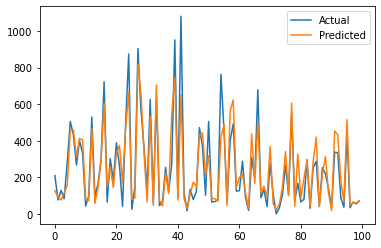

In [20]:
data.head(100).plot()

# All frequent articles

------------article : Milch-------------
Lasso score=0.47098472101999156
Lasso rmse=141.30097929707688
Lasso r2=0.4724606653169491
MLP score=0.23959794377950017
MLP rmse=168.24398070846337
MLP r2=0.2520999290052539
Adaboost score=0.68274009839812
Adaboost rmse=117.35890905779615
Adaboost r2=0.6360877866943921
Random forest score=0.9807295723386584
Random forest rmse=68.12309743452711
Random forest r2=0.877382268715189
Extra tree score=0.9999989694722302
Extra tree rmse=80.18086032806177
Extra tree r2=0.8301342083566496


<AxesSubplot:title={'center':'Milch'}>

------------article : Pfandartikel-------------
Lasso score=0.5905560130359456
Lasso rmse=1249.4953654142455
Lasso r2=0.6700521309978749
MLP score=0.0008464146672770845
MLP rmse=2230.5131967832904
MLP r2=-0.051442730576169104
Adaboost score=0.6636186438592979
Adaboost rmse=1398.2188709966497
Adaboost r2=0.5868323146829998
Random forest score=0.9873618976105023
Random forest rmse=525.3753034711543
Random forest r2=0.9416668624517187
Extra tree score=0.9999999943572864
Extra tree rmse=609.3637162994054
Extra tree r2=0.9215253818758198


<AxesSubplot:title={'center':'Pfandartikel'}>

------------article : Schlaufentragetasche ST-------------
Lasso score=0.5316657080318472
Lasso rmse=72.08265160326079
Lasso r2=0.5659124634402635
MLP score=0.4366062675455452
MLP rmse=78.68463526655088
MLP r2=0.4827557391181161
Adaboost score=0.8147306606255027
Adaboost rmse=53.68402453603066
Adaboost r2=0.7592280218336391
Random forest score=0.9879233749429936
Random forest rmse=31.884982766536112
Random forest r2=0.9150647084816096
Extra tree score=0.9999974917634622
Extra tree rmse=36.893557309117085
Extra tree r2=0.8862852310856161


<AxesSubplot:title={'center':'Schlaufentragetasche ST'}>

------------article : BO-Laugenbreze 1ST-------------
Lasso score=0.5398555016026032
Lasso rmse=145.99359629808401
Lasso r2=0.5521356452573423
MLP score=0.07960184207640886
MLP rmse=210.56400204873867
MLP r2=0.06836212157546806
Adaboost score=0.7086852389646126
Adaboost rmse=142.2165443775174
Adaboost r2=0.5750095915584941
Random forest score=0.9779293296954076
Random forest rmse=86.88790926379335
Random forest r2=0.8413655236548436
Extra tree score=0.9999997189163988
Extra tree rmse=96.56870435827011
Extra tree r2=0.804047100438774


<AxesSubplot:title={'center':'BO-Laugenbreze 1ST'}>

------------article : Avocado vorgereift ST-------------
Lasso score=0.41735559179867654
Lasso rmse=72.97123737154838
Lasso r2=0.4370134726890592
MLP score=0.3908561143038206
MLP rmse=74.36257369965148
MLP r2=0.4153399687843188
Adaboost score=0.6523112296994997
Adaboost rmse=65.12163726131493
Adaboost r2=0.5516210635979463
Random forest score=0.9900111893931746
Random forest rmse=27.375630243462265
Random forest r2=0.9207639470854386
Extra tree score=0.9999981406676255
Extra tree rmse=31.100180443302058
Extra tree r2=0.8977365598505158


<AxesSubplot:title={'center':'Avocado vorgereift ST'}>

------------article : VL Eier BH 10ST -------------
Lasso score=0.4500348356812568
Lasso rmse=54.06565331379019
Lasso r2=0.48204892616847617
MLP score=0.3847147503993754
MLP rmse=58.340010090544375
MLP r2=0.39691458295368076
Adaboost score=0.7199847937885872
Adaboost rmse=36.71072980899739
Adaboost r2=0.7612013517837617
Random forest score=0.9885406017304185
Random forest rmse=20.79305186657134
Random forest r2=0.923390557650367
Extra tree score=0.9999994539799305
Extra tree rmse=25.868046836190427
Extra tree r2=0.8814304683227869


<AxesSubplot:title={'center':'VL Eier BH 10ST '}>

------------article : M.I. Mozzarella oGt 125g-------------
Lasso score=0.5491292439789015
Lasso rmse=56.30311310974588
Lasso r2=0.5443028263275846
MLP score=0.5389358214756934
MLP rmse=58.106911166159136
MLP r2=0.5146365177089998
Adaboost score=0.7903279527138658
Adaboost rmse=39.66588782050248
Adaboost r2=0.7738243346282896
Random forest score=0.9889604573966517
Random forest rmse=22.671813609458052
Random forest r2=0.9261102762388517
Extra tree score=0.9999976457036709
Extra tree rmse=28.384932846882265
Extra tree r2=0.8841790133651106


<AxesSubplot:title={'center':'M.I. Mozzarella oGt 125g'}>

------------article : Gurken ST-------------
Lasso score=0.465999180104258
Lasso rmse=133.23285614937038
Lasso r2=0.47639751931369656
MLP score=0.30174267026290025
MLP rmse=151.39526854405443
MLP r2=0.3239113820244175
Adaboost score=0.7407745540406736
Adaboost rmse=92.61553387988792
Adaboost r2=0.7469847557276375
Random forest score=0.9882956001401617
Random forest rmse=56.449506283311536
Random forest r2=0.9060061767730221
Extra tree score=0.9999981345387395
Extra tree rmse=69.98429627952788
Extra tree r2=0.8555291529242866


<AxesSubplot:title={'center':'Gurken ST'}>

------------article : Broetchen-------------
Lasso score=0.3847186174096122
Lasso rmse=490.94105865873007
Lasso r2=0.392405165834503
MLP score=-0.02639089216679813
MLP rmse=655.0114862851892
MLP r2=-0.08156641976905776
Adaboost score=0.631595513526338
Adaboost rmse=408.02314432149035
Adaboost r2=0.5803135383746664
Random forest score=0.9818726025743321
Random forest rmse=238.1672210524147
Random forest r2=0.8570054972450474
Extra tree score=0.9999999095533276
Extra tree rmse=322.8770984116455
Extra tree r2=0.7371972855571993


<AxesSubplot:title={'center':'Broetchen'}>

------------article : GL Sahne 30% 200g VLOG-------------
Lasso score=0.44176008407557066
Lasso rmse=54.726012392624426
Lasso r2=0.4092056958614545
MLP score=0.42373142749301596
MLP rmse=54.8306798498047
MLP r2=0.4069436610947099
Adaboost score=0.7514755770709735
Adaboost rmse=38.73505311131006
Adaboost r2=0.7040236553558585
Random forest score=0.9879181376323122
Random forest rmse=24.706364162124792
Random forest r2=0.8795889433145277
Extra tree score=0.9999984486858216
Extra tree rmse=26.819539049825323
Extra tree r2=0.8581101566168001


<AxesSubplot:title={'center':'GL Sahne 30% 200g VLOG'}>

------------article : Bananen Lose-------------
Lasso score=0.42834578182246363
Lasso rmse=77.10043931721218
Lasso r2=0.47015778864223456
MLP score=0.28321388913869827
MLP rmse=85.58049126767017
MLP r2=0.34719661205587127
Adaboost score=0.7621594640188949
Adaboost rmse=60.54259634432611
Adaboost r2=0.6732956384427443
Random forest score=0.9901681678146713
Random forest rmse=30.838174067987147
Random forest r2=0.9152362503115911
Extra tree score=1.0
Extra tree rmse=35.59987946581744
Extra tree r2=0.8870386420957617


<AxesSubplot:title={'center':'Bananen Lose'}>

------------article : Zeitschriften 7%-------------
Lasso score=0.348519678364962
Lasso rmse=79.86325777082172
Lasso r2=0.35370619740501485
MLP score=0.11763561775175213
MLP rmse=94.98620087600396
MLP r2=0.08576681133676844
Adaboost score=0.7774602077418012
Adaboost rmse=49.47702564817837
Adaboost r2=0.7519477817292806
Random forest score=0.9910838968367176
Random forest rmse=19.341308063560795
Random forest r2=0.9620940284536407
Extra tree score=0.999995463748514
Extra tree rmse=19.591866326667773
Extra tree r2=0.9611055561787847


<AxesSubplot:title={'center':'Zeitschriften 7%'}>

------------article : Kiwi Gruen ST-------------
Lasso score=0.3503897230503785
Lasso rmse=96.14686616248667
Lasso r2=0.33550246301039743
MLP score=0.32038427486500975
MLP rmse=99.110244011907
MLP r2=0.29390977420903464
Adaboost score=0.6312349481493167
Adaboost rmse=64.92616150492816
Adaboost r2=0.6969860907169769
Random forest score=0.9728393185577562
Random forest rmse=52.02509235538623
Random forest r2=0.8054421185120799
Extra tree score=0.9999931794481417
Extra tree rmse=62.29107889396712
Extra tree r2=0.7210831094148986


<AxesSubplot:title={'center':'Kiwi Gruen ST'}>

------------article : AugustinerHellMW1x0,5LFL-------------
Lasso score=0.5205310668859056
Lasso rmse=82.18961481933857
Lasso r2=0.501456206509311
MLP score=0.45678894982587726
MLP rmse=87.49082173653164
MLP r2=0.43507029043694645
Adaboost score=0.6558354746716553
Adaboost rmse=71.74557010591647
Adaboost r2=0.6201084744808412
Random forest score=0.9710115199824286
Random forest rmse=41.18009321168515
Random forest r2=0.8748461902429859
Extra tree score=0.9999969593683626
Extra tree rmse=42.08214609917726
Extra tree r2=0.8693031311098326


<AxesSubplot:title={'center':'AugustinerHellMW1x0,5LFL'}>

------------article : SammelNr. Lose Backwaren-------------
Lasso score=0.33336436933337243
Lasso rmse=894.2738168901568
Lasso r2=0.3862937527292133
MLP score=-0.7442429768714534
MLP rmse=1559.0490662421726
MLP r2=-0.8652587261827966
Adaboost score=0.7878411622648324
Adaboost rmse=538.2328080052642
Adaboost r2=0.7776895658511294
Random forest score=0.9567050444884186
Random forest rmse=486.8856103781805
Random forest r2=0.8180829552433082
Extra tree score=1.0
Extra tree rmse=355.51750060065024
Extra tree r2=0.903006756732214


<AxesSubplot:title={'center':'SammelNr. Lose Backwaren'}>

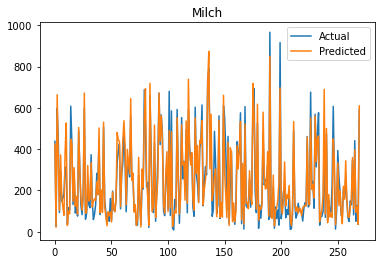

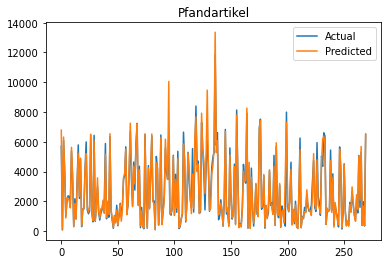

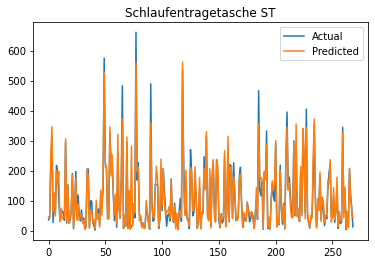

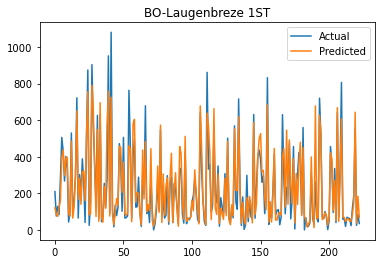

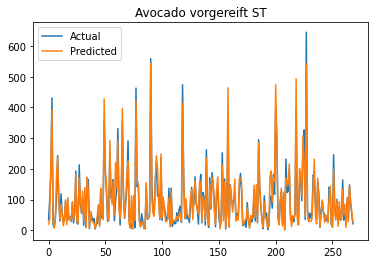

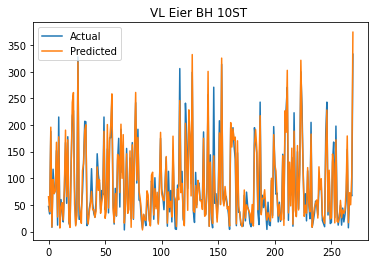

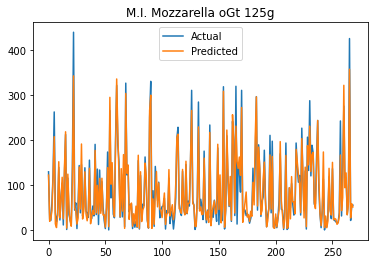

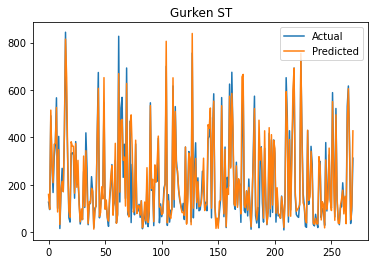

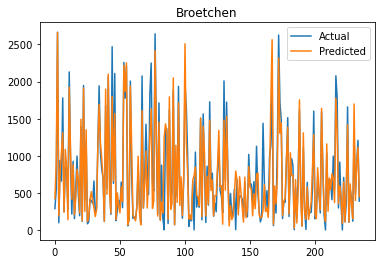

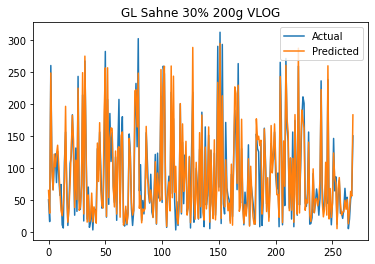

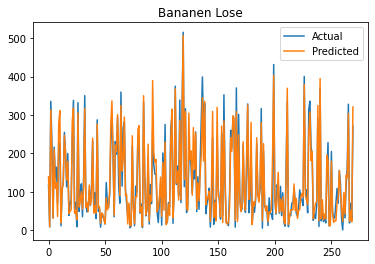

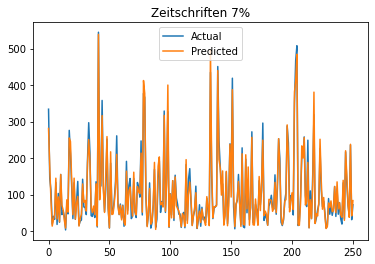

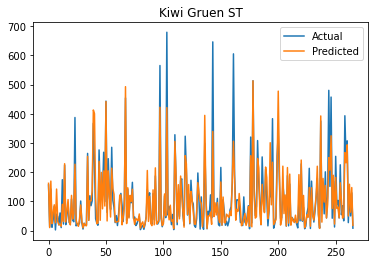

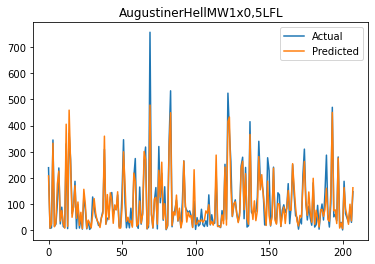

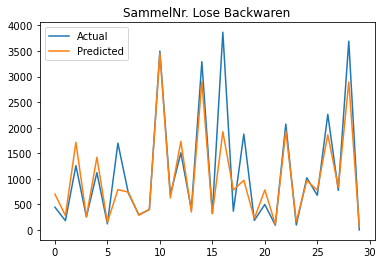

In [12]:
lasso_dict = {'score':0 , 'rmse':0, 'r2':0}
mlp_dict = {'score':0 , 'rmse':0, 'r2':0}
ada_dict = {'score':0 , 'rmse':0, 'r2':0}
rf_dict = {'score':0 , 'rmse':0, 'r2':0}
et_dict = {'score':0 , 'rmse':0, 'r2':0}

for article_name in list(df['Group'].unique()):
    # select article
    print(f"------------article : {article_name}-------------")
    article = df.loc[:,['StoreNumber', 'Month', 'Quantity', 'Day', 'Hour']][df.Group == article_name]
    article = article.groupby(['StoreNumber', 'Month', 'Day', 'Hour'])['Quantity'].sum().reset_index()

    # separate features and outcome
    x = article.drop('Quantity', axis=1)
    encoder = LabelEncoder()
    for col in x.columns:
        x[col] = encoder.fit_transform(x[col])
    y = article['Quantity']

    # # standardize features value into [0,1]
    # scaler = MinMaxScaler(copy=True, feature_range=(0,1))
    # x = pd.DataFrame(scaler.fit_transform(x), columns=x.keys())

    # # set train data and test data
    x_train,x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=0)

    # apply machine learning algo
    # Lasso
    lasso = Lasso()
    lasso.fit(x_train,y_train)
    y_lasso = lasso.predict(x_test)

    # Neural Network
    mlp = MLPRegressor()
    mlp.fit(x_train,y_train)
    y_mlp = mlp.predict(x_test)

    # Adaboost
    ada = AdaBoostRegressor()
    ada.fit(x_train,y_train)
    y_ada = ada.predict(x_test)

    # Random forest
    rf=RandomForestRegressor()
    rf.fit(x_train,y_train)
    y_rf = rf.predict(x_test)

    # Extra tree
    et = ExtraTreesRegressor()
    et.fit(x_train,y_train)
    y_et = et.predict(x_test)

    # show results
    # Lasso
    print(f'Lasso score={lasso.score(x_train, y_train)}')
    print(f'Lasso rmse={mse(y_test, y_lasso, squared=False)}')
    print(f'Lasso r2={r2(y_test, y_lasso)}')
    lasso_dict['score'] += lasso.score(x_train, y_train)
    lasso_dict['rmse'] += mse(y_test, y_lasso, squared=False)
    lasso_dict['r2'] += r2(y_test, y_lasso)

    # MLP
    print(f'MLP score={mlp.score(x_train, y_train)}')
    print(f'MLP rmse={mse(y_test, y_mlp, squared=False)}')
    print(f'MLP r2={r2(y_test, y_mlp)}')
    mlp_dict['score'] += mlp.score(x_train, y_train)
    mlp_dict['rmse'] += mse(y_test, y_mlp, squared=False)
    mlp_dict['r2'] += r2(y_test, y_mlp)

    # Adaboost
    print(f'Adaboost score={ada.score(x_train, y_train)}')
    print(f'Adaboost rmse={mse(y_test, y_ada, squared=False)}')
    print(f'Adaboost r2={r2(y_test, y_ada)}')
    ada_dict['score'] += ada.score(x_train, y_train)
    ada_dict['rmse'] += mse(y_test, y_ada, squared=False)
    ada_dict['r2'] += r2(y_test, y_ada)
    
    # Random forest
    print(f'Random forest score={rf.score(x_train, y_train)}')
    print(f'Random forest rmse={mse(y_test, y_rf, squared=False)}')
    print(f'Random forest r2={r2(y_test, y_rf)}')
    rf_dict['score'] += rf.score(x_train, y_train)
    rf_dict['rmse'] += mse(y_test, y_rf, squared=False)
    rf_dict['r2'] += r2(y_test, y_rf)

    # Extra tree
    print(f'Extra tree score={et.score(x_train, y_train)}')
    print(f'Extra tree rmse={mse(y_test, y_et, squared=False)}')
    print(f'Extra tree r2={r2(y_test, y_et)}')
    et_dict['score'] += et.score(x_train, y_train)
    et_dict['rmse'] += mse(y_test, y_et, squared=False)
    et_dict['r2'] += r2(y_test, y_et)
    
    # plot
    data = pd.DataFrame({'Actual': y_test, 'Predicted': y_rf}).reset_index().drop(columns='index')
    display(data.plot(title=f'{article_name}'))

In [13]:
num_article = df.Group.nunique()
print(f'average Lasso score : {lasso_dict["score"]/num_article}')
print(f'average Lasso rmse : {lasso_dict["rmse"]/num_article}')
print(f'average Lasso r2 : {lasso_dict["r2"]/num_article}')

print(f'average MLP score : {mlp_dict["score"]/num_article}')
print(f'average MLP rmse : {mlp_dict["rmse"]/num_article}')
print(f'average MLP r2 : {mlp_dict["r2"]/num_article}')

print(f'average Adaboost score : {ada_dict["score"]/num_article}')
print(f'average Adaboost rmse : {ada_dict["rmse"]/num_article}')
print(f'average Adaboost r2 : {ada_dict["r2"]/num_article}')

print(f'average Random forest score : {rf_dict["score"]/num_article}')
print(f'average Random forest rmse : {rf_dict["rmse"]/num_article}')
print(f'average Random forest r2 : {rf_dict["r2"]/num_article}')

print(f'average Extra tree score : {et_dict["score"]/num_article}')
print(f'average Extra tree rmse : {et_dict["rmse"]/num_article}')
print(f'average Extra tree r2 : {et_dict["r2"]/num_article}')

average Lasso score : 0.4548806744130497
average Lasso rmse : 246.71243457123282
average Lasso r2 : 0.4699367279668917
average MLP score : 0.21360147430310816
average MLP rmse : 377.7513045717821
average MLP r2 : 0.2016426342517041
average Adaboost score : 0.7180517013022647
average Adaboost rmse : 211.8182997853407
average Adaboost r2 : 0.6796769310305772
average Random forest score : 0.9827567140756405
average Random forest rmse : 115.51367721534355
average Random forest r2 : 0.8909364202916147
average Extra tree score : 0.9999982340135675
average Extra tree rmse : 122.8748935699005
average Extra tree r2 : 0.85984745026167
